In [1]:
import copy
import numpy as np
import pandas as pd
import seaborn as sns
import os
import matplotlib.pyplot as plt
import time
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

import keras
from keras import initializers
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from keras.constraints import max_norm
from scipy.stats import pearsonr
from scipy.stats import expon

from time import time
import math

import random
from scipy.misc import comb

Using TensorFlow backend.


In [2]:
### TUNING PARAMETERS ###

observations = 1199                    # Sample construction
X_val_size = 199
n_split = 5
                      
N_nodes = [1, 2, 3]                    # Design MLP                       
t=0
#H_layers = [1, 2, 3, 4, 5, 10]
H_layers = [1, 2, 3, 5, 10]

m = 0                                  # Distribution parameters
sd = 1               
alpha = 0.5
beta = 0.5
lambd = 1.5
a = 0.25
b = 0.75

                                       # Grid search hyperparameters
batch_size = [10, 25, 50, 100]
epochs = [50, 100, 500]

dropout_rate = [i/5 for i in range(0,5)]
learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
weight_constraint = [0, 3, 5]

neurons = [2, 3, 5, 10, 20, 30]

                                       #grid_search or random_search?
search = "random_search"
n_iter_search = 10

t_size = 0.4

In [6]:
### FUNCTIONS ###

def create_dataset():
    x = np.array([[random.expovariate(lambd) for i in range(N_nodes[t])] for i in range(0, observations+1)])
    y = np.array([0.95*i/observations+0.05 for i in range(0,observations+1)])
    
    #check dimensionality
    print('dimensionality of x :', np.shape(x))
    print('dimensionality of y: ', np.shape(y))
    
    #sort
    x_sorted = np.sort(x,0)

    #correlation
    for i in range(N_nodes[t]):
        print("correlation for " +str(N_nodes[t])+ ": ",pearsonr(x_sorted[:,0], y))
    
    print('\n')
    return (x_sorted,y)

def scale(x):
    ### scale ###
    mean = np.mean(x, axis=0)
    var = np.var(x, axis=0)
    print("mean is: ", mean)
    print("variance is: ", var)

    x_scaled = np.array([(i-mean)/np.sqrt(var) for i in x])
    
    print('\n')
    return x_scaled


def plot_dataset(x, y):
    
    for i in range(N_nodes[t]):
        plt.scatter(x[:,i], y, c=y)
        plt.ylabel('Cumulative Probability < RV value')
        plt.xlabel('Random Variable (RV) value')
        plt.plot(x[:,i], expon.cdf(x[:,i], scale=1/lambd), label="actual CDF")
        plt.colorbar(ticks=np.linspace(min(y), max(y), 10, endpoint=True))
        plt.show()
    

def plot_cdf(X_train, Y_train, X_test, Y_test, X_train_scaled, X_test_scaled, predictions):
        for i in range(N_nodes[t]):
            plt.scatter(X_test[:,i], Y_test, label='test set')
            plt.scatter(X_test[:,i], predictions, label='fitted set')
            plt.scatter(X_test[:,i], expon.cdf(X_test[:,i],scale=1/lambd), label="actual CDF")

            plt.ylabel('Cumulative Probability < RV value')
            plt.xlabel('Random Variable (RV) value')
            plt.legend()
            plt.show()
        
def create_model(H_layers=1, optimizer='Adam', init=initializers.RandomNormal(mean=0, stddev=0.25, seed=None), activation='sigmoid', dropout_rate=0.0, learn_rate=0.01, neurons=1, weight_constraint=0):
#def create_model(optimizer, init, dropout_rate, learn_rate, activation, neurons, weight_constraint):
    ### CREATE MODEL ###
    MLP = Sequential()
    #MLP.add(Dropout(dropout_rate, input_shape=(N_nodes[t],)))
    MLP.add(Dense(neurons, input_dim=N_nodes[t], kernel_initializer=init, activation=activation, kernel_constraint=max_norm(weight_constraint)))    #hidden layer
    #MLP.add(Dropout(dropout_rate))
    for h in range(1,H_layers):                                                                     #multiple hidden layers
        MLP.add(Dense(neurons, kernel_initializer=init, activation=activation, kernel_constraint=max_norm(weight_constraint)))
        #MLP.add(Dropout(dropout_rate))
    MLP.add(Dense(1, kernel_initializer=init, activation='sigmoid'))                                 #output layer
    MLP.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])
    
    return MLP

def train_ANN(search, X_train, Y_train, X_test):
    
    model = keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_model, verbose=0)
    print('Keras wrapper done')
    param = dict(epochs=epochs, batch_size=batch_size, neurons=neurons, H_layers=H_layers, learn_rate=learn_rate, weight_constraint=weight_constraint)
    #param = dict(neurons=neurons, H_layers=H_layers, learn_rate=learn_rate, weight_constraint=weight_constraint)
    
    if (search == 'random_search'):
        print('RANDOM SEARCH')
        grid = RandomizedSearchCV(estimator=model, param_distributions=param, n_iter=n_iter_search, n_jobs=1)
        print('Grid is prepared')
        start = time()
        grid.fit(X_train, Y_train)
        #grid.fit(X_train, Y_train, batch_size=500, epochs=1000)
        print("RandomizedSearchCV took %.2f seconds for %d candidates"
              " parameter settings." % ((time() - start), n_iter_search))
    else:
        print('GRIDSEARCH')
        grid = GridSearchCV(estimator=model, param_grid=param, n_jobs=1)
        print('Grid is prepared')
        start = time()
        grid.fit(X_train, Y_train)
        #grid.fit(X_train, Y_train, batch_size=500, epochs=1000)
        print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
              % (time() - start, len(grid.cv_results_['params'])))

    # summarize results (smallest loss?)
    print("Best: %f using %s" % (-grid.best_score_, grid.best_params_))
    means = grid.cv_results_['mean_test_score']
    stds = grid.cv_results_['std_test_score']
    params = grid.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (-mean, stdev, param))
    
    predictions = grid.best_estimator_.predict(X_test)
    
    print('\n')
    return (grid, predictions)

def run_ANN(X_train, Y_train, X_test):
    
    model = create_model(H_layers=H_layers, learn_rate=learn_rate, neurons=neurons, weight_constraint=weight_constraint)
    print('Keras wrapper done')
    model.compile(loss='mean_squared_error', optimizer='Adam', metrics=['mae'])
    model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, verbose=0)
        
    predictions = model.predict(X_test)
    
    print('\n')
    return (model, predictions)

def activation_function(x):
    return 1/(1+math.exp(-x))

### CHECK PROCEDURE ON TEST SET ###

def run_ANN_manually(X_val, X_val_scaled):
    #assuming biases are included
    b = 0
    k = 0
    #print('k', k)
    temp_saved = np.zeros([len(X_val_scaled), H_layers+1, neurons])
    predictions = np.zeros([len(X_val_scaled)])
    #print('temp_saved', temp_saved)
    while (H_layers-k)>=0:
        #print('while (H_layers-k)>=0:' ,H_layers-k)
        if (k==0):
            #print('k==0')
            for i in range(len(X_val_scaled)):
                #print('i', i)
                for j in range(neurons):
                    #print('j', j)
                    for l in range(N_nodes[t]):
                        #print('l', l)
                        temp_saved[i][k][j] += X_val_scaled[i][l]*weights[b][l][j]
                        #print('temp_saved', temp_saved)
                    temp_saved[i][k][j] += 1*weights[b+1][j]
                    #print('temp_saved', temp_saved)
                    temp_saved[i][k][j] = activation_function(temp_saved[i][k][j])
            #print('temp_saved', temp_saved)
            b += 2
            k += 1
        elif((H_layers-k)>0 and k!=0):
            #print('(H_layers-k)>0 and k!=0')
            #print('k', k)
            for i in range(len(X_val_scaled)):
                #print('i', i)
                for j in range(neurons):
                    #print('j', j)
                    for l in range(neurons):
                        #print('l', l)
                        temp_saved[i][k][j] += temp_saved[i][k-1][l]*weights[b][l][j]
                        #print('temp_saved', temp_saved)
                    temp_saved[i][k][j] += 1*weights[b+1][j]
                    #print('1*weights[k+2][j]', 1*weights[k+2][j])
                    #print('temp_saved', temp_saved)
                    temp_saved[i][k][j] = activation_function(temp_saved[i][k][j])
            #print('temp_saved', temp_saved)
            b += 2
            k += 1
        elif(H_layers-k)==0:
            #print('(H_layers-k)==0')
            #print('k', k)
            for i in range(len(X_val_scaled)):
                #print('i', i)
                for l in range(neurons):
                    #print('l', l)
                    temp_saved[i][k][0] += temp_saved[i][k-1][l]*weights[b][l][0]
                    predictions[i] += temp_saved[i][k-1][l]*weights[b][l][0]
                    #print('temp_saved', temp_saved)
                temp_saved[i][k][0] += 1*weights[b+1][0]
                predictions[i] += 1*weights[b+1][0]
                #print('temp_saved', temp_saved)
                temp_saved[i][k][0] = activation_function(temp_saved[i][k][0])
                predictions[i] = activation_function(predictions[i])
            #print('temp_saved', temp_saved)
            k += 1                                                     #stop while-loop

    plot_cdf(X_test, Y_test, X_val, Y_val, X_test_scaled, X_val_scaled, predictions)

    return (temp_saved, predictions)

def derivative_sigmoid(x):
    return 1/(1+math.exp(-x))*(1-1/(1+math.exp(-x)))



dimensionality of x : (1200, 1)
dimensionality of y:  (1200,)
correlation for 1:  (0.87326995123660889, 0.0)




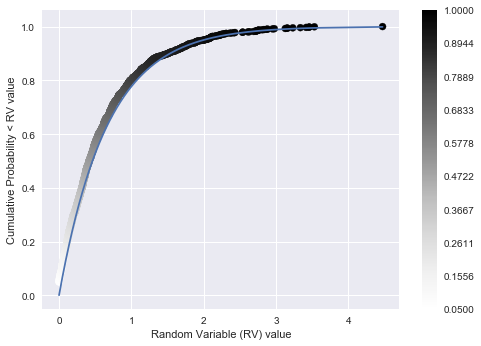

dimensionality of X_val: 	 (200, 1)
dimensionality of Y_val: 	 (200,)
dimensionality of x : 		 (1000, 1)
dimensionality of y: 		 (1000,) 

Simulations
1 : TRAIN:  800 TEST:  200
X_train sample: 800 Y_train sample: 800
first entry of sample X_test [ 0.00064211] first entry of sample Y_test 0.05 

X_train scaling:
mean is:  [ 0.64557918]
variance is:  [ 0.39863262]


X_test scaling:
mean is:  [ 0.60577024]
variance is:  [ 0.33660269]


MLP created
Keras wrapper done
RANDOM SEARCH
Grid is prepared
RandomizedSearchCV took 739.27 seconds for 10 candidates parameter settings.
Best: 0.003132 using {'weight_constraint': 3, 'neurons': 30, 'learn_rate': 0.1, 'epochs': 500, 'batch_size': 50, 'H_layers': 3}
0.158311 (0.105955) with: {'weight_constraint': 0, 'neurons': 30, 'learn_rate': 0.1, 'epochs': 100, 'batch_size': 25, 'H_layers': 5}
0.009396 (0.005542) with: {'weight_constraint': 5, 'neurons': 20, 'learn_rate': 0.001, 'epochs': 50, 'batch_size': 10, 'H_layers': 2}
0.156850 (0.104922) with: {'

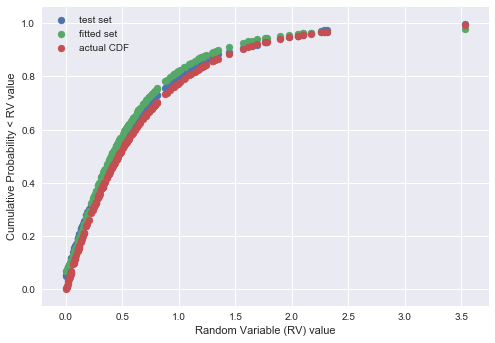

2 : TRAIN:  800 TEST:  200
X_train sample: 800 Y_train sample: 800
first entry of sample X_test [ 0.0009895] first entry of sample Y_test 0.0515846538782 

X_train scaling:
mean is:  [ 0.62697588]
variance is:  [ 0.39169396]


X_test scaling:
mean is:  [ 0.68018344]
variance is:  [ 0.36336027]


MLP created
Keras wrapper done
RANDOM SEARCH
Grid is prepared
RandomizedSearchCV took 1760.88 seconds for 10 candidates parameter settings.
Best: 0.011351 using {'weight_constraint': 3, 'neurons': 3, 'learn_rate': 0.1, 'epochs': 500, 'batch_size': 25, 'H_layers': 1}
0.011351 (0.007838) with: {'weight_constraint': 3, 'neurons': 3, 'learn_rate': 0.1, 'epochs': 500, 'batch_size': 25, 'H_layers': 1}
0.156358 (0.104927) with: {'weight_constraint': 0, 'neurons': 10, 'learn_rate': 0.1, 'epochs': 500, 'batch_size': 100, 'H_layers': 1}
0.156087 (0.104735) with: {'weight_constraint': 3, 'neurons': 3, 'learn_rate': 0.01, 'epochs': 100, 'batch_size': 25, 'H_layers': 10}
0.156494 (0.105025) with: {'weight_c

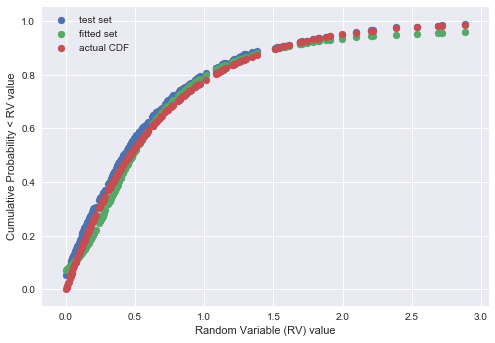

3 : TRAIN:  800 TEST:  200
X_train sample: 800 Y_train sample: 800
first entry of sample X_test [ 0.00067774] first entry of sample Y_test 0.0507923269391 

X_train scaling:
mean is:  [ 0.63167401]
variance is:  [ 0.37932174]


X_test scaling:
mean is:  [ 0.66139093]
variance is:  [ 0.4144075]


MLP created
Keras wrapper done
RANDOM SEARCH
Grid is prepared
RandomizedSearchCV took 884.39 seconds for 10 candidates parameter settings.
Best: 0.013596 using {'weight_constraint': 5, 'neurons': 30, 'learn_rate': 0.001, 'epochs': 500, 'batch_size': 25, 'H_layers': 10}
0.013596 (0.009589) with: {'weight_constraint': 5, 'neurons': 30, 'learn_rate': 0.001, 'epochs': 500, 'batch_size': 25, 'H_layers': 10}
0.155326 (0.104790) with: {'weight_constraint': 0, 'neurons': 10, 'learn_rate': 0.001, 'epochs': 100, 'batch_size': 100, 'H_layers': 2}
0.156422 (0.105599) with: {'weight_constraint': 0, 'neurons': 30, 'learn_rate': 0.3, 'epochs': 100, 'batch_size': 50, 'H_layers': 1}
0.120605 (0.083611) with: {'

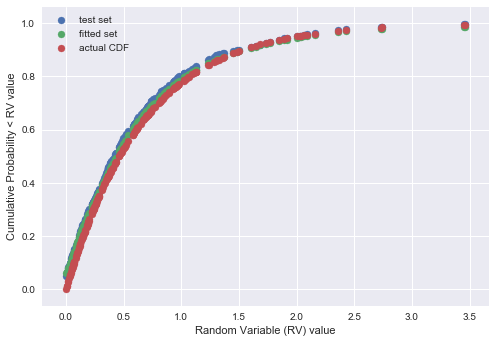

4 : TRAIN:  800 TEST:  200
X_train sample: 800 Y_train sample: 800
first entry of sample X_test [ 0.00288594] first entry of sample Y_test 0.0547539616347 

X_train scaling:
mean is:  [ 0.63824376]
variance is:  [ 0.36421802]


X_test scaling:
mean is:  [ 0.63511192]
variance is:  [ 0.47552105]


MLP created
Keras wrapper done
RANDOM SEARCH
Grid is prepared
RandomizedSearchCV took 1235.64 seconds for 10 candidates parameter settings.
Best: 0.006282 using {'weight_constraint': 3, 'neurons': 20, 'learn_rate': 0.1, 'epochs': 500, 'batch_size': 50, 'H_layers': 1}
0.006282 (0.005479) with: {'weight_constraint': 3, 'neurons': 20, 'learn_rate': 0.1, 'epochs': 500, 'batch_size': 50, 'H_layers': 1}
0.013785 (0.013742) with: {'weight_constraint': 5, 'neurons': 10, 'learn_rate': 0.001, 'epochs': 100, 'batch_size': 25, 'H_layers': 2}
0.157109 (0.105512) with: {'weight_constraint': 0, 'neurons': 5, 'learn_rate': 0.3, 'epochs': 100, 'batch_size': 50, 'H_layers': 1}
0.008559 (0.008633) with: {'weight

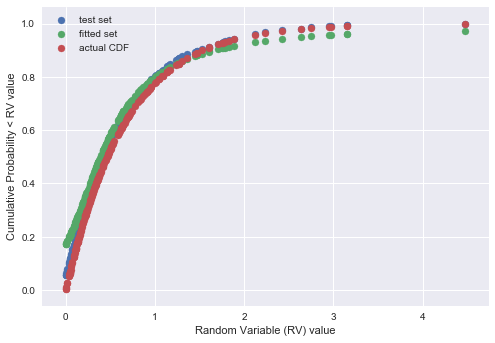

5 : TRAIN:  800 TEST:  200
X_train sample: 800 Y_train sample: 800
first entry of sample X_test [ 0.00163135] first entry of sample Y_test 0.0523769808173 

X_train scaling:
mean is:  [ 0.64561413]
variance is:  [ 0.39825832]


X_test scaling:
mean is:  [ 0.60563043]
variance is:  [ 0.33808871]


MLP created
Keras wrapper done
RANDOM SEARCH
Grid is prepared
RandomizedSearchCV took 1836.95 seconds for 10 candidates parameter settings.
Best: 0.006236 using {'weight_constraint': 5, 'neurons': 10, 'learn_rate': 0.1, 'epochs': 500, 'batch_size': 10, 'H_layers': 3}
0.156191 (0.104835) with: {'weight_constraint': 0, 'neurons': 30, 'learn_rate': 0.1, 'epochs': 500, 'batch_size': 25, 'H_layers': 3}
0.041375 (0.037968) with: {'weight_constraint': 5, 'neurons': 30, 'learn_rate': 0.2, 'epochs': 50, 'batch_size': 50, 'H_layers': 2}
0.157361 (0.105646) with: {'weight_constraint': 0, 'neurons': 20, 'learn_rate': 0.2, 'epochs': 100, 'batch_size': 100, 'H_layers': 1}
0.108185 (0.077521) with: {'weight_

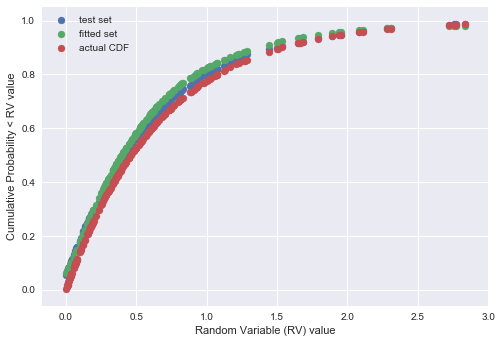

In [4]:
### K-FOLD SIMULATIONS ###

best_score = np.empty([n_split,])
dict_H_layers = np.empty([n_split,])
dict_learn_rate = np.empty([n_split,])
dict_neurons = np.empty([n_split,])
dict_weight_constraint = np.empty([n_split,])
dict_epochs = np.empty([n_split,])
dict_batch_size = np.empty([n_split,])
all_X_test_scaled = np.empty([n_split,int((observations+1-X_val_size-1)/n_split)])
all_predictions = np.empty([n_split,int((observations+1-X_val_size-1)/n_split)])

#create dataset
x, y = create_dataset()
plot_dataset(x, y)

#take validation set out

#X_val = x[0:(X_val_size+1)]
#x = x[(X_val_size+1):(observations+1)]
#Y_val = y[0:(X_val_size+1)]
#y = y[(X_val_size+1):(observations+1)]

#index = [random.randint(0,(observations+1)) for i in range(X_val_size+1)]
index = np.random.choice(observations+1, X_val_size+1, replace=False)
X_val = x[index]
Y_val = y[index]

x = np.delete(x, index, 0)
y = np.delete(y, index, 0)

index_sort = np.argsort(X_val[:,0])
X_val = X_val[index_sort]
Y_val = Y_val[index_sort]

print('dimensionality of X_val: \t', np.shape(X_val))
print('dimensionality of Y_val: \t', np.shape(Y_val))
print('dimensionality of x : \t\t', np.shape(x))
print('dimensionality of y: \t\t', np.shape(y), '\n')

kf = KFold(n_splits=n_split, shuffle=True, random_state=None)
kf.get_n_splits(x)
k = 1

print('Simulations')
M = 0
for train_index, test_index in kf.split(x):
    
    #create k-fold sets
    print(k, ':', 'TRAIN: ', len(train_index), 'TEST: ', len(test_index))
    #print('TRAIN: ', train_index, 'TEST: ', test_index)
    X_train, X_test = x[train_index], x[test_index]
    Y_train, Y_test = y[train_index], y[test_index]
    print('X_train sample:', len(X_train), 'Y_train sample:', len(Y_train))
    print('first entry of sample X_test', X_test[0], 'first entry of sample Y_test', Y_test[0], '\n')

    print('X_train scaling:')
    X_train_scaled = scale(X_train)
    print('X_test scaling:')
    X_test_scaled = scale(X_test)

    MLP = create_model()
    print('MLP created')
    grid, predictions = train_ANN(search, X_train_scaled, Y_train, X_test_scaled)
    plot_cdf(X_train, Y_train, X_test, Y_test, X_train_scaled, X_test_scaled, predictions)
    ###

    best_score[M] = -grid.best_score_
    dict_H_layers[M] = grid.best_params_['H_layers']
    dict_learn_rate[M] = grid.best_params_['learn_rate']
    dict_neurons[M] = grid.best_params_['neurons']
    dict_weight_constraint[M] = grid.best_params_['weight_constraint']
    dict_epochs[M] = grid.best_params_['epochs']
    dict_batch_size[M] = grid.best_params_['batch_size']
    all_predictions[M] = predictions
    all_X_test_scaled[M] = X_test_scaled[:,0]
    
    k += 1
    M += 1

Best error score:  0.00313226820097 

Chosen structure:  { weight_constraint:  3.0 , neurons:  30.0 , learn_rate 0.1 , epochs:  500.0 , batch_size 50.0 , H_layers 3.0 }
Keras wrapper done




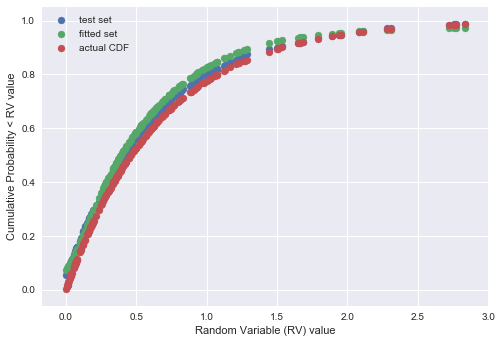

length weights 8
layers length: (weight + possible bias) 30
layers length: (weight + possible bias) 30
layers length: (weight + possible bias) 900
layers length: (weight + possible bias) 30
layers length: (weight + possible bias) 900
layers length: (weight + possible bias) 30
layers length: (weight + possible bias) 30
layers length: (weight + possible bias) 1


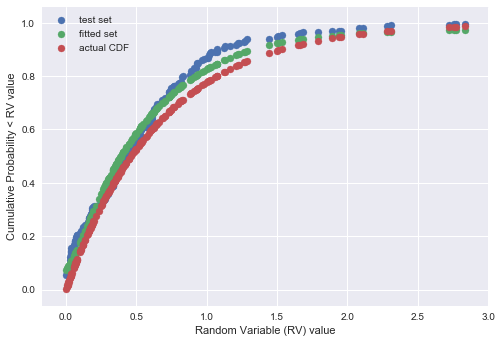

differences between keras and self-constructed-procedure: 
 [  4.54450970e-08   1.76514725e-08   3.37033776e-08   5.67708888e-09
   3.01402623e-08   2.78857600e-08   4.90613704e-08   2.27947221e-08
   2.47015225e-09   9.89308628e-09   1.24268253e-08   1.71166653e-08
   5.57530060e-09   3.73056860e-09   1.32192634e-08   3.14584368e-08
   2.49334342e-08   2.24610368e-09   7.16491863e-09   4.54528018e-09
   1.95346806e-08   2.09292906e-08   4.32325042e-09   7.98397737e-10
   5.96301264e-09   2.99529286e-08   1.42557969e-08   5.33798691e-09
   4.24074691e-08   2.10077190e-08   3.84572219e-08   1.28693359e-09
   4.48490367e-08   7.40492975e-08   2.97355382e-09   7.13238571e-09
   6.42814607e-10   2.48574460e-08   3.40691331e-09   2.00577713e-08
   5.60025895e-09   8.69807892e-09   2.07303942e-08   5.17700576e-08
   1.93442803e-08   6.15935808e-09   6.30178972e-08   9.69884550e-09
   4.88408915e-08   2.03270625e-08   3.04685279e-08   3.94177173e-08
   1.01698415e-08   8.65017208e-09   2.3474

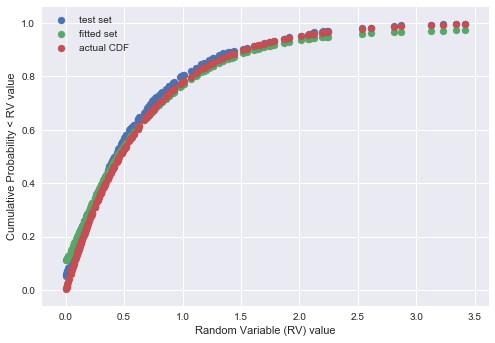

In [7]:
#choose structure for MLP
print("Best error score: ", np.amin(best_score), "\n")
print("Chosen structure: ", '{ weight_constraint: ',dict_weight_constraint[np.argmin(best_score)],', neurons: ', dict_neurons[np.argmin(best_score)], ', learn_rate', dict_learn_rate[np.argmin(best_score)], ', epochs: ', dict_epochs[np.argmin(best_score)], ', batch_size', dict_batch_size[np.argmin(best_score)], ', H_layers', dict_H_layers[np.argmin(best_score)],'}' )

# fix hyperparameters
weight_constraint = int(dict_weight_constraint[np.argmin(best_score)])
neurons = int(dict_neurons[np.argmin(best_score)])
learn_rate = dict_learn_rate[np.argmin(best_score)]
epochs = int(dict_epochs[np.argmin(best_score)])
batch_size = int(dict_batch_size[np.argmin(best_score)])
H_layers = int(dict_H_layers[np.argmin(best_score)])

#run on last test set ONLY (?)
model, predictions = run_ANN(X_train_scaled, Y_train, X_test_scaled)
plot_cdf(X_train, Y_train, X_test, Y_test, X_train_scaled, X_test_scaled, predictions)

#retrieve these weights
#(map weights MLP to validation set)
weights = model.get_weights()
print("length weights", len(weights))
for i in range(len(weights)):
    print("layers length: (weight + possible bias)", weights[i].size)

#print(model.get_weights())
#print(model.get_config())

### CHECK PROCEDURE ON TEST SET ###
temp_not_saved, Tpredictions = run_ANN_manually(X_test, X_test_scaled)
### WARNING (still small differences)
np.in1d(predictions,Tpredictions)
diff = predictions[:,0]-Tpredictions
print('differences between keras and self-constructed-procedure: \n', abs(diff))

### MAP TESTWEIGHTS ON VALSET ###
print('X_val scaling:')
X_val_scaled = scale(X_val)
temp_saved, predictions = run_ANN_manually(X_val, X_val_scaled)

In [12]:
def derivative(): 
    #i = len(temp_saved[0])-1
    i = 0
    k = len(weights)-2
    print('iterator temp_saved i: ', i, 'iterator weights k: ', k)

    #neurons last hidden layer
    temp_first = np.zeros([len(predictions), neurons])
    for obs in range(len(predictions)):
        #print('obs', obs)
        for j in range(neurons):
            #print('j', j)
            temp_first[obs][j] = weights[k][j][0]
    #print('temp_first', temp_first)
    k -= 2
    #i -= 1
    #i += 1
    print('temp_first (neurons last hidden layer)', temp_first[0], '\n')
    print('iterator temp_saved i: ', i, 'iterator weights k: ', k)

    #temp_layers (neurons middle layers)
    if H_layers > 1:
        temp_layers = dict()
        for q in range(0, (H_layers-1)):
            print('NEW LAYER')
            print('q', q)
            temp_layers[q] = np.zeros([len(predictions), neurons])
            for obs in range(len(predictions)):
                print('NEW OBS')
                print('obs', obs)
                for p in range(neurons):
                    print('p', p)
                    if(q==0):
                        print('IF')
                        for l in range(neurons):
                            print('l', l)
                            temp_sum = 0
                            for m in range(neurons):
                                print('m', m)
                                print('weights[',k,'][',m,'][',l,']')
                                print('temp_saved[',obs,'][',q,'][',m,']')
                                temp_sum += temp_saved[obs][q][m]*weights[k][m][l]
                            temp_layers[q][obs][p] += temp_first[obs][l]*derivative_sigmoid(temp_sum+weights[k+1][p])*weights[k][p][l]
                    else:
                        print('ELSE')
                        for l in range(neurons):
                            print('l', l)
                            temp_sum = 0
                            for m in range(neurons):
                                print('m', m)
                                print('weights[',k,'][',m,'][',l,']')
                                print('temp_saved[',obs,'][',q,'][',m,']')
                                temp_sum += temp_saved[obs][q][m]*weights[k][m][l]
                            temp_layers[q][obs][p] += temp_layers[q-1][obs][l]*derivative_sigmoid(temp_sum+weights[k+1][p])*weights[k][p][l]

            k -= 2
            i += 1

    print('iterator temp_saved i: ', i, 'iterator weights k: ', k)

    #derivative input layer

    temp_last = np.zeros([len(predictions), N_nodes[t]])
    for obs in range(len(predictions)):
        #print('obs', obs)
        for pp in range(N_nodes[t]):
            #print('pp', pp)
            for p in range(neurons):
                #print('p', p)
                if H_layers == 1:
                    #print('IF')
                    temp_sum = 0
                    for l in range(neurons):
                        #print('l', l)
                        for m in range(N_nodes[t]):
                            #print('k', k)
                            temp_sum += weights[0][m][l]*X_val[obs][m]
                    temp_last[obs][pp] += temp_first[obs][p]*derivative_sigmoid(temp_sum+weights[k+1][pp])*weights[0][0][pp] 
                else:
                    #print('ELSE')
                    temp_sum = 0
                    for l in range(neurons):
                        for m in range(N_nodes[t]):
                            temp_sum += weights[0][m][l]*X_val[obs][m]
                    temp_last[obs][pp] += temp_layers[(H_layers-2)][obs][p]*derivative_sigmoid(temp_sum+weights[k+1][pp])*weights[0][0][pp] 
    return temp_last

In [ ]:
### DERIVATIVE H=? ###
temp_last = derivative()

for i in range(N_nodes[t]):
    #plt.scatter(X_val_scaled, temp_last[:,0], label="scaled fitted set")
    #plt.scatter(X_val_scaled, expon.pdf(X_test,scale=1/lambd), label="scaled actual PDF")
    plt.scatter(X_val[:,i], temp_last[:,i], label="fitted set")
    plt.scatter(X_val[:,i], expon.pdf(X_test[:,i],scale=1/lambd), label="actual PDF")
    plt.legend()
    plt.show()

for i in range(N_nodes[t]):
    plt.scatter(X_val[:,i], temp_last[:,i], label="fitted set")
    plt.legend()
    plt.show()

iterator temp_saved i:  0 iterator weights k:  6
temp_first (neurons last hidden layer) [-0.34313297 -0.32398787 -0.47385553  0.00281921  0.25585377 -0.68759328
  0.61017483 -0.43438417 -0.38200608  0.24720083  0.36914343  0.32236576
 -0.48945212 -0.36179176  0.31792504  0.24462342 -0.41768104 -0.98068029
  0.59658754  0.57095814 -0.4405764  -0.46868134  0.13473362  0.53733408
  0.21668155 -0.34896913 -0.28596851  0.16831748 -0.77265906  0.5797146 ] 

iterator temp_saved i:  0 iterator weights k:  4
NEW LAYER
q 0
NEW OBS
obs 0
p 0
IF
l 0
m 0
weights[ 4 ][ 0 ][ 0 ]
temp_saved[ 0 ][ 0 ][ 0 ]
m 1
weights[ 4 ][ 1 ][ 0 ]
temp_saved[ 0 ][ 0 ][ 1 ]
m 2
weights[ 4 ][ 2 ][ 0 ]
temp_saved[ 0 ][ 0 ][ 2 ]
m 3
weights[ 4 ][ 3 ][ 0 ]
temp_saved[ 0 ][ 0 ][ 3 ]
m 4
weights[ 4 ][ 4 ][ 0 ]
temp_saved[ 0 ][ 0 ][ 4 ]
m 5
weights[ 4 ][ 5 ][ 0 ]
temp_saved[ 0 ][ 0 ][ 5 ]
m 6
weights[ 4 ][ 6 ][ 0 ]
temp_saved[ 0 ][ 0 ][ 6 ]
m 7
weights[ 4 ][ 7 ][ 0 ]
temp_saved[ 0 ][ 0 ][ 7 ]
m 8
weights[ 4 ][ 8 ][ 0 ]
temp_

In [9]:
H_layers

3